In [1]:
import tensorflow as tf
import numpy as np
from cleverhans.attacks import FastGradientMethod
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import graph_util

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [3]:
tf.reset_default_graph()

In [4]:
# generate noise pattern (shape (1,784))
def fixed_pattern(sigma, probability):
    pattern = []
    p = np.array([probability[0], probability[1], probability[2]])
    size = np.uint16(784)
    for i in range(0,size):
        e = np.random.choice([sigma[0], sigma[1], sigma[2]], p=p.ravel())
        pattern.append(e)
    pattern = np.array(pattern)
    return pattern

In [5]:
# Load data
mnist_raw = input_data.read_data_sets("./mnist/data/", one_hot=True)
X_raw_train = mnist_raw.train.images
Y_raw_train = mnist_raw.train.labels
X_raw_test = mnist_raw.test.images
Y_raw_test = mnist_raw.test.labels

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [6]:
# add noise
sigma = [0.1, 0, -0.1]
probability = [0.2, 0.6, 0.2]
mnist_process = input_data.read_data_sets("./mnist/data/", one_hot=True)
pattern = fixed_pattern(sigma, probability)
for i in range(0, 55000):
    mnist_process.train.images[i] = mnist_process.train.images[i] + pattern
for i in range(0, 5000):
    mnist_process.test.images[i] = mnist_process.test.images[i] + pattern
X_process_train = mnist_process.train.images
Y_process_train = mnist_process.train.labels
X_process_test = mnist_process.test.images
Y_process_test = mnist_process.test.labels

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [7]:
# variables
X_r = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xr")
Y_r = tf.placeholder(tf.float32, [None, 10])
X_p = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xp")
Y_p = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)

In [8]:
def conv2d(input_, output_dim, 
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.01,
       name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
             initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
    return conv
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                    tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
        initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

In [9]:
class ModelCNN(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.built = False
    def __call__(self, input, reuse=False):
        with tf.variable_scope("model", reuse=reuse) as scope:
            x = conv2d(input, 32,3,3,1,1, name='conv1')
            x = tf.nn.relu(x)
            x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            x = conv2d(x, 64,3,3,1,1, name='conv2')
            x = tf.nn.relu(x)
            x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            x = tf.reshape(x, [-1, 7 * 7 * 64])
            x = linear(x,1024,scope='fc1')
            x = tf.nn.relu(x)
            x = tf.nn.dropout(x, keep_prob)
            out_raw = linear(x,self.num_classes,scope='fc2')
            out_softmax = tf.nn.softmax(out_raw, name="softmax")
        return out_raw, out_softmax

In [10]:
model = ModelCNN(10)

In [11]:
output_logits_real, output_real   = model(X_r)
output_logits_fake, output_fake   = model(X_p, reuse=True)

In [12]:
# custom loss
alpha = 1.
beta = 1.
gama = 0.01
loss_r = alpha * tf.reduce_mean(tf.reduce_sum(Y_r * output_real, -1))
loss_p = beta * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_logits_fake, labels=Y_p))
loss_d = gama * tf.reduce_mean(tf.square(X_r - X_p))

total_loss = loss_r+loss_p+loss_d

In [13]:
# calculate accuracy
correct_prediction1 = tf.equal(tf.argmax(output_fake,1), \
        tf.argmax(Y_p,1))
accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, "float"))

correct_prediction2 = tf.equal(tf.argmax(output_real,1), \
        tf.argmax(Y_r,1))
accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, "float"))

In [14]:
t_vars = tf.trainable_variables()
model_var = open('model_var.txt','a+')
for var in t_vars:
    model_var.write(str(var)+'\n')
model_var.close()

In [15]:
global_step = tf.Variable(0, trainable=False)
lr_decayed = tf.train.exponential_decay(0.001, global_step, 10000, 0.1, staircase=False)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_decayed).minimize(total_loss)

In [16]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [17]:
batch_size = 128
total_batch = int(mnist_raw.train.num_examples / batch_size)
print(total_batch)

429


In [18]:
loss = open('loss.txt','a+')
acc = open('acc.txt','a+')
for epoch in range(100):
    for i in range(total_batch):
        batch_xr, batch_yr = mnist_raw.train.next_batch(batch_size)
        batch_xp, batch_yp = mnist_process.train.next_batch(batch_size)
        batch_xr = batch_xr.reshape(-1, 28, 28, 1)
        batch_xp = batch_xp.reshape(-1, 28, 28, 1)

        #_, cost_val = 
        _, loss_,temp_loss1, temp_loss2, temp_acc1,temp_acc2 = sess.run([optimizer, total_loss,loss_r,loss_p,accuracy2,accuracy1],
                               feed_dict={X_r: batch_xr,
                                          Y_r: batch_yr,
                                          X_p: batch_xp,
                                          Y_p: batch_yp,
                                          keep_prob: 0.5})
        if i % 50 == 0:
            print(temp_loss1, temp_loss2)
            print(temp_acc1,temp_acc2)
    loss.write(str(temp_loss1)+' '+str(temp_loss2)+'\n')
    acc.write(str(temp_acc1)+' '+str(temp_acc2)+'\n')

loss.close()
acc.close()

0.09999064 2.3024848
0.0625 0.1015625
0.60788214 0.65853465
0.796875 0.859375
0.40963796 0.6023228
0.5 0.828125
0.109333515 0.2352302
0.1015625 0.90625
0.14991602 0.16509938
0.1484375 0.953125
0.08686234 0.17840792
0.0859375 0.9140625
0.1503311 0.19749166
0.1484375 0.9296875
0.0867897 0.053294897
0.0859375 0.9765625
0.11432132 0.10203728
0.109375 0.96875
0.0861715 0.09744961
0.0859375 0.984375
0.13295832 0.09442661
0.1328125 0.953125
0.13333055 0.070115596
0.1328125 0.96875
0.11780698 0.10985289
0.1171875 0.9765625
0.07086485 0.12583695
0.0703125 0.9453125
0.117303416 0.08785427
0.1171875 0.96875
0.09389965 0.06905848
0.09375 0.9921875
0.10328004 0.061942846
0.1015625 0.9765625
0.09524194 0.069690034
0.09375 0.9765625
0.1486031 0.12988743
0.1484375 0.9609375
0.08621661 0.040020492
0.0859375 0.9921875
0.12501402 0.059600696
0.125 0.9921875
0.08606083 0.04992329
0.0859375 0.9765625
0.11126266 0.060877632
0.109375 0.9921875
0.102482334 0.022438701
0.1015625 0.9921875
0.08598353 0.04293101

0.109375 0.027570315
0.109375 0.9921875
0.1015625 0.010881164
0.1015625 0.9921875
0.078125 0.0014095985
0.078125 1.0
0.13281251 0.004971343
0.1328125 1.0
0.1015625 0.004956073
0.1015625 1.0
0.078125 0.006371086
0.078125 0.9921875
0.109375 3.0549116e-05
0.109375 1.0
0.125 4.790674e-05
0.125 1.0
0.078125 0.0005432521
0.078125 1.0
0.0625 0.0030643013
0.0625 1.0
0.14843792 0.012955474
0.1484375 0.9921875
0.125 0.0006654646
0.125 1.0
0.07143777 0.0003724089
0.0703125 1.0
0.12503044 0.0003749725
0.125 1.0
0.125 0.005944276
0.125 1.0
0.125 0.00024061115
0.125 1.0
0.101562545 0.00023300719
0.1015625 1.0
0.1171875 0.004249837
0.1171875 1.0
0.0546875 0.014483044
0.0546875 0.9921875
0.109375 0.025737163
0.109375 0.984375
0.07031251 2.2958671e-05
0.0703125 1.0
0.1015625 0.0014484589
0.1015625 1.0
0.1015625 0.020229988
0.1015625 0.9921875
0.109375 4.7452362e-05
0.109375 1.0
0.0859375 0.0012738009
0.0859375 1.0
0.0703125 0.015526506
0.0703125 0.9921875
0.109375 0.00047825946
0.109375 1.0
0.0859375 0

0.078125 0.0002580423
0.078125 1.0
0.1015625 0.00016496524
0.1015625 1.0
0.0859375 1.7478145e-05
0.0859375 1.0
0.1015625 0.007500613
0.1015625 0.9921875
0.0703125 3.764961e-05
0.0703125 1.0
0.0859375 5.9231274e-07
0.0859375 1.0
0.078125 0.002643504
0.078125 1.0
0.0625 6.922139e-05
0.0625 1.0
0.1015625 2.1424343e-05
0.1015625 1.0
0.109375 0.0011182242
0.109375 1.0
0.125 1.1240775e-06
0.125 1.0
0.109375 3.7655103e-05
0.109375 1.0
0.046875 0.00035305443
0.046875 1.0
0.1328125 0.0014754834
0.1328125 1.0
0.109375 0.0003530464
0.109375 1.0
0.1171875 6.244389e-06
0.1171875 1.0
0.0546875 0.000107515094
0.0546875 1.0
0.109375 1.8347028e-07
0.109375 1.0
0.078125 3.4547318e-06
0.078125 1.0
0.078125 4.2973134e-05
0.078125 1.0
0.1015625 0.003491846
0.1015625 1.0
0.1171875 6.968707e-05
0.1171875 1.0
0.0859375 0.00021860441
0.0859375 1.0
0.109375 0.00016952492
0.109375 1.0
0.10156255 3.519351e-05
0.1015625 1.0
0.109375 0.008639795
0.109375 0.9921875
0.1484375 1.5291676e-05
0.1484375 1.0
0.125 0.00040

0.1328125 4.775467e-06
0.1328125 1.0
0.0703125 0.001030729
0.0703125 1.0
0.109375 0.00015916573
0.109375 1.0
0.0859375 8.2334016e-05
0.0859375 1.0
0.0859375 1.9429344e-05
0.0859375 1.0
0.1171875 3.5142628e-05
0.1171875 1.0
0.0546875 3.974482e-06
0.0546875 1.0
0.09375 1.7220797e-05
0.09375 1.0
0.078125 0.00011084964
0.078125 1.0
0.0703125 1.8253846e-07
0.0703125 1.0
0.09375 2.2248264e-06
0.09375 1.0
0.125 5.55015e-05
0.125 1.0
0.0390625 0.0048025437
0.0390625 1.0
0.09375 1.7553539e-05
0.09375 1.0
0.0859375 1.7545133e-06
0.0859375 1.0
0.1015625 5.5879223e-08
0.1015625 1.0
0.125 3.1306201e-06
0.125 1.0
0.0703125 0.004269285
0.0703125 1.0
0.0625 7.301274e-07
0.0625 1.0
0.0625 2.136346e-06
0.0625 1.0
0.1015625 1.210719e-08
0.1015625 1.0
0.1171875 1.4220512e-05
0.1171875 1.0
0.09375 7.948533e-06
0.09375 1.0
0.0859375 2.6958826e-06
0.0859375 1.0
0.0703125 2.1855801e-06
0.0703125 1.0
0.09375 5.38694e-05
0.09375 1.0
0.0859375 0.00012248306
0.0859375 1.0
0.1015625 0.0012650004
0.1015625 1.0
0.10

0.0625 2.588867e-06
0.0625 1.0
0.1015625 0.0029530074
0.1015625 1.0
0.078125 6.137247e-07
0.078125 1.0
0.1484375 1.8253775e-07
0.1484375 1.0
0.109375 5.7088135e-07
0.109375 1.0


In [19]:
saver = tf.train.Saver()
saver.save(sess,"./checkpoint_dir/MyModel")

'./checkpoint_dir/MyModel'

In [24]:
# test raw input
Accuracy = np.array([])
for i in range(total_batch):
    batch_xr, batch_yr = mnist_raw.train.next_batch(batch_size)
    batch_xp, batch_yp = mnist_process.train.next_batch(batch_size)
    batch_xr = batch_xr.reshape(-1, 28, 28, 1)
    batch_xp = batch_xp.reshape(-1, 28, 28, 1)

    #_, cost_val = 
    temp_acc = sess.run(accuracy2,
                           feed_dict={X_r: batch_xr,
                                      Y_r: batch_yr,
                                      X_p: batch_xp,
                                      Y_p: batch_yp,
                                      keep_prob: 0.5
                           })
    Accuracy = np.insert(Accuracy ,0, temp_acc )
print('accuracy: %.3f' % np.mean(Accuracy))
print("test accuracy %g" %accuracy1.eval(session = sess,
      feed_dict={X_r: batch_xr,
                                      Y_r: batch_yr,
                                      X_p: batch_xp,
                                      Y_p: batch_yp,
                                      keep_prob: 0.5
                           }))

accuracy: 0.099
test accuracy 1


In [25]:
max_epsilon = 16.0
eps = 2.0 * max_epsilon / 255.0

In [26]:
x_adv = X_r - eps * tf.sign(tf.gradients(total_loss, X_r)[0])
x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)

In [27]:
checkpoint_path = "checkpoint_dir/MyModel"
session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master="")

with tf.train.MonitoredSession(session_creator=session_creator) as sess:
    nontargeted_images = sess.run(x_adv, feed_dict={
                                    X_r: batch_xr,
                                    Y_r: batch_yr,
                                    X_p: batch_xp,
                                    Y_p: batch_yp,
                                    keep_prob: 0.5})

INFO:tensorflow:Restoring parameters from checkpoint_dir/MyModel


In [28]:
import pylab
import matplotlib.pyplot as plt

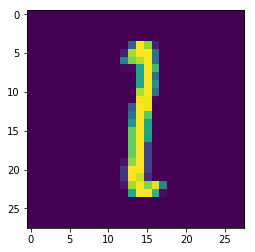

In [29]:
pylab.imshow(mnist_raw.train.images[3].reshape(-1,28))

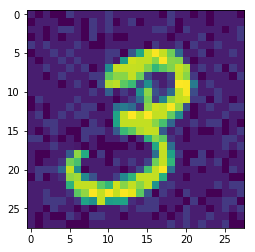

In [30]:
pylab.imshow(X_process_train[1].reshape(-1,28))

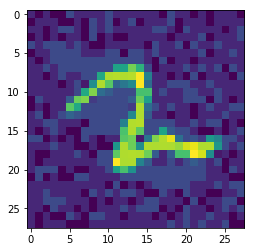

In [31]:
pylab.imshow(nontargeted_images[3].reshape(-1,28))

In [34]:
import cv2
from PIL import Image
print(nontargeted_images[5].reshape(28,28)*255)

[[  0.         -32.           0.         -32.         -32.
   32.           0.           0.           0.           0.
   32.           0.           0.           0.           0.
    0.           0.         -32.          32.           0.
    0.         -32.           0.         -32.           0.
    0.           0.         -32.        ]
 [-32.           0.           0.           0.         -32.
  -32.           0.         -32.          32.           0.
   32.         -32.           0.          32.         -32.
    0.           0.           0.          32.         -32.
    0.           0.           0.         -32.           0.
    0.           0.           0.        ]
 [  0.           0.         -32.           0.          32.
   32.           0.         -32.          32.           0.
   32.           0.           0.           0.           0.
    0.          32.          32.           0.         -32.
   32.           0.           0.           0.           0.
  -32.           0.          32

In [ ]:
for i in range(16):
    im = nontargeted_images[i].reshape(28,28)
    img= Image.fromarray(im*255)
    img = img.convert('RGB')
    img.save('out/cv2_%s.bmp'%i,'bmp')
    # 2.imwrite('out/cv2_{}.png'.format(str(i).zfill(3)), img)